# The Chi-Squared Test for Proportions (or Independence)


> Use Case
- Used to compare observed and expected frequencies of categorical data, particularly when comparing proportions across different categorical groups.
- Used for feature selection, to determine is a feature is a good predictor.
> Assumptions
- The data must be categorical and fit into a contingency table.
- The expected frequency in each cell of the contingency table should be at least 5 (to ensure the validity of the test).
> Example Scenario
- Comparing the satisfaction levels of customers (Satisfied/Not Satisfied) between two different versions of a website.
> Null Hypothesis (H0):
- Feature Selection: The categories are independent
- Proportions: The proportion of successes is the same for both groups.
> Alternative Hypothesis (H1):
- Feature Selection: The categories are dependent
- Proportions: The proportion of successes is different for both groups.

In [508]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# statsmodels==0.12.2
from statsmodels.stats.power import GofChisquarePower
from statsmodels.stats.proportion import proportions_chisquare

# scipy==1.12.0
from scipy.stats import chi2_contingency

# pingouin==0.5.4
from pingouin import chi2_independence, power_chi2 


In [509]:
import statsmodels
statsmodels.__version__

'0.12.2'

In [510]:
import scipy
scipy.__version__

'1.12.0'

In [511]:
import pingouin
pingouin.__version__

'0.5.4'

In [512]:
# Set random seed for reproducibility
np.random.seed(42)

In [513]:
# set seaborn style
sns.set(style="white", palette="mako")

# remove some borders    
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

### Power Analysis

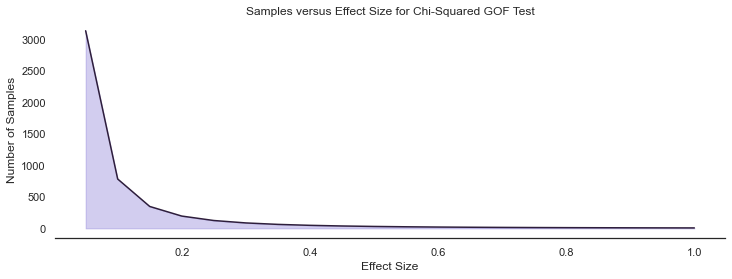

In [514]:
# Initialize GofChisquarePower
gof_power = GofChisquarePower()

# Given power and alpha
alpha=0.05
power=0.8

# Define effect sizes
effect_sizes = np.linspace(0.05, 1, 20) 
# Calculate number of samples for each effect size
samples = [gof_power.solve_power(effect_size=effect_size, nobs=None, alpha=alpha, power=power) for effect_size in effect_sizes]

# Figure size
plt.figure(figsize=(12, 4))

# Plot samples versus effect sizes
plt.plot(effect_sizes, samples)

# Shade area below the line with lower opacity
plt.fill_between(effect_sizes, samples, color='slateblue', alpha=0.3)

# Add plot labels and title
plt.xlabel('Effect Size')
plt.ylabel('Number of Samples')
plt.title('Samples versus Effect Size for Chi-Squared GOF Test')
plt.show()


In [515]:
# Chi-Squared Power Analysis (scipy)

# Degree of freedom (depends on the chosen test).
dof=3
# Cohen’s w effect size
w=0.3
# Test power (= 1 - type II error).
power=0.8
# Significance level (type I error probability).
alpha=0.05
# Exactly ONE of the parameters w, n, power and alpha must be passed as None, and that parameter is determined from the others. 
n=None

# The degrees of freedom dof must always be specified
sample_size = power_chi2(dof=dof, w=w, n=n, power=power, alpha=alpha)

print(f"There are {int(np.ceil(sample_size))} samples required per group")

There are 122 samples required per group


In [516]:
# Chi-Squared Power Analysis (statsmodels)

# Effect size
effect_size = 0.3
# Significance level (type I error probability).
alpha = 0.05
# Test power (= 1 - type II error).
power = 0.8
# Degree of freedom + 1 (depends on the chosen test).
n_bins=4
# Exactly ONE of the parameters must be passed as None, and that parameter is determined from the others. 
nobs = None

# The degrees of freedom dof must always be specified
sample_size = GofChisquarePower().solve_power(effect_size=effect_size, nobs=nobs, alpha=alpha, power=power, n_bins=n_bins)

print(f"There are {int(np.ceil(sample_size))} samples required per group")

There are 122 samples required per group


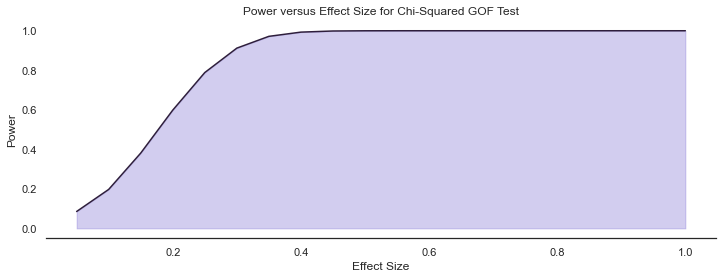

In [517]:
# Initialize GofChisquarePower
gof_power = GofChisquarePower()

# Given alpha 
alpha=0.05
# Given prior determined sample size
nobs = 122


# Define effect sizes
effect_sizes = np.linspace(0.05, 1, 20)  
# Calculate power for each effect size
powers = [gof_power.solve_power(effect_size=effect_size, nobs=nobs, alpha=alpha) for effect_size in effect_sizes]

# Figure size
plt.figure(figsize=(12, 4))

# Plot power versus effect sizes
plt.plot(effect_sizes, powers)

# Shade area below the line with lower opacity
plt.fill_between(effect_sizes, powers, color='slateblue', alpha=0.3)

# Add plot labels and title
plt.xlabel('Effect Size')
plt.ylabel('Power')
plt.title('Power versus Effect Size for Chi-Squared GOF Test')
plt.show()


### Synthetic Data

In [518]:
# Number of samples for each version
n_samples = 500

# Generate synthetic data for two website versions
version_A = np.random.choice(['Satisfied', 'Not Satisfied'], size=n_samples, p=[0.25, 0.75])
version_B = np.random.choice(['Satisfied', 'Not Satisfied'], size=n_samples, p=[0.15, 0.85])


# Create pandas dataframe
chi_squared_data = pd.DataFrame({'Version_A': version_A, 'Version_B': version_B})
chi_squared_data

,Version_A,Version_B
0,Not Satisfied,Not Satisfied
1,Not Satisfied,Not Satisfied
2,Not Satisfied,Not Satisfied
3,Not Satisfied,Not Satisfied
4,Satisfied,Not Satisfied
...,...,...
495,Not Satisfied,Satisfied
496,Not Satisfied,Not Satisfied
497,Satisfied,Satisfied
498,Not Satisfied,Not Satisfied


In [519]:
# We'll use these later to build arrays to plug into the statistical functions

a_positive = chi_squared_data['Version_A'].value_counts()['Satisfied']
a_negative = chi_squared_data['Version_A'].value_counts()['Not Satisfied']

b_positive = chi_squared_data['Version_B'].value_counts()['Satisfied']
b_negative = chi_squared_data['Version_B'].value_counts()['Not Satisfied']


### Check Assumptions

In [520]:
# Assumption check for chi-squared test
observed_counts = pd.crosstab(chi_squared_data['Version_A'], chi_squared_data['Version_B'])
min_expected_count = 5

# Check if expected counts in each cell are at least > min_expected_count
expected_counts = np.outer(observed_counts.sum(axis=1), observed_counts.sum(axis=0)) / chi_squared_data.shape[0]
assumption_met = np.all(expected_counts >= min_expected_count)

print(f"Chi-Squared Test Assumption: Expected counts in each cell are at least {min_expected_count} - {'Met' if assumption_met else 'Not Met'}")


Chi-Squared Test Assumption: Expected counts in each cell are at least 5 - Met


### Chi-Squared Test (scipy)

In [521]:
# Pre-determined alpha value
alpha = 0.05

In [522]:
# Assuming chi-squared assumptions are met

# Contingency table
# observed_counts = np.array([[a_positive, a_negative], [a_positive, a_negative]])
observed_counts = np.array([[a_positive, a_negative], [b_positive, b_negative]])

# Chi-squared test
res = chi2_contingency(observed_counts, correction=True)

chi2_stat = res.statistic
p_value = res.pvalue
dof = res.dof
expected_freq = res.expected_freq

# Similar categorical variables should present low chi-squared statistic and high p-value.
print(f"Chi-Squared Test Statistic: {chi2_stat}")
print(f"p-value: {p_value}")
print(f"dof: {dof}")
print(f"expected_freq: {expected_freq}")
print("\n")


# Check for statistical significance
if p_value < alpha:
    conclusion = "Reject the null hypothesis. The categories are likely dependent"
    interpretation = "There is a significant difference in satisfaction levels between the two website versions."

else:
    conclusion = "Fail to reject the null hypothesis. The categories are likely independent"
    interpretation = "There is no significant difference in satisfaction levels between the two website versions."


print(conclusion)
print(interpretation)


Chi-Squared Test Statistic: 16.472637997940918
p-value: 4.935727253513574e-05
dof: 1
expected_freq: [[103.5 396.5]
 [103.5 396.5]]


Reject the null hypothesis. The categories are likely dependent
There is a significant difference in satisfaction levels between the two website versions.


### Chi-Squared Test (pingouin)

In [523]:
# # Pre-determined alpha value
# alpha = 0.05

In [524]:

# # Perform chi-squared test for proportions using pingouin (bootstrap)
# expected, observed, stats = chi2_independence(chi_squared_data, x='Version_A', y='Version_B', correction=True)

# print(f'Expected Counts:')
# display(expected)

# print(f'\nObserved Counts:')
# display(observed)

# # Similar categorical variables should present low chi-squared statistics and high p-values.
# print("Summary Stats:")
# display(stats.round(3))

# avg_p = stats['pval'].mean()

# # Check for statistical significance
# if avg_p < alpha:
#     conclusion = "Reject the null hypothesis. The categories are likely dependent"
#     interpretation = "There is a significant difference in satisfaction levels between the two website versions."
# else:
#     conclusion = "Fail to reject the null hypothesis. The categories are likely independent"
#     interpretation = "There is no significant difference in satisfaction levels between the two website versions."

# print(conclusion)
# print(interpretation)

### Chi-Squared Test (statsmodels)

In [525]:
# Pre-determined alpha value
alpha = 0.05

In [526]:
# Contingency table
# observed_counts = [a_positive, a_positive]
observed_counts = [a_positive, b_positive]

# Get the total number of observations for all categories
nobs = np.array((chi_squared_data.shape[0], chi_squared_data.shape[0]))



# Perform chi-squared test for proportions
chi2_stat, p_value, (table, expected)  = proportions_chisquare(observed_counts, nobs=nobs, value=None)

# Similar categorical variables should present low chi-squared statistics and high p-values.
print(f"Chi-Squared Test Statistic: {chi2_stat}")
print(f"p-value: {p_value}")
print(f"table: {table}")
print(f"expected_freq: {expected}")
print("\n")

# Check for statistical significance
if p_value < alpha:
    conclusion = "Reject the null hypothesis. The categories are likely dependent"
    interpretation = "There is a significant difference in satisfaction levels between the two website versions."
else:
    conclusion = "Fail to reject the null hypothesis. The categories are likely independent"
    interpretation = "There is no significant difference in satisfaction levels between the two website versions."

print(conclusion)
print(interpretation)


Chi-Squared Test Statistic: 17.11229294978404
p-value: 3.523351422873548e-05
table: [[130 370]
 [ 77 423]]
expected_freq: [[103.5 396.5]
 [103.5 396.5]]


Reject the null hypothesis. The categories are likely dependent
There is a significant difference in satisfaction levels between the two website versions.


### Difference in Proportions and 95% Confidence Interval

In [527]:
# Calculate proportions
n_a = a_positive + a_negative
n_b = b_positive + b_negative
prop_a = a_positive / n_a
prop_b = b_positive / n_b

# Calculate standard errors
se_a = np.sqrt(prop_a * (1 - prop_a) / n_a)
se_b = np.sqrt(prop_b * (1 - prop_b) / n_b)

# Calculate standard error of the difference
se_diff = np.sqrt(se_a**2 + se_b**2)

# Critical value for 95% confidence interval (df=1)
critical_value = 3.841  # From chi-squared distribution table

# Margin of error
margin_of_error = np.sqrt(chi2_stat / dof) * se_diff

# Calculate confidence interval
diff_proportion = prop_b - prop_a
lower_bound = diff_proportion - margin_of_error
upper_bound = diff_proportion + margin_of_error

# Print results
print("\n")
print(f"Difference in Proportions: {diff_proportion}")
print(f"95% Confidence Interval of Difference in Proportions: [{lower_bound}, {upper_bound}]")



Difference in Proportions: -0.10600000000000001
95% Confidence Interval of Difference in Proportions: [-0.21108913491135145, -0.0009108650886485575]


### Effect Size

In [532]:
# Number of observations
n = len(chi_squared_data)

# Number of rows and columns
n_rows, n_cols = chi_squared_data.shape

# Calculate Cramer's V
cramers_v = np.sqrt(chi2_stat / (n * min(n_rows - 1, n_cols - 1)))

print(f"Cramer's V: {cramers_v}")
if cramers_v == 0:
    print("There is no association between the variables.")
elif cramers_v <= 0.1:
    print("There is a weak association between the variables.")
elif cramers_v <= 0.3:
    print("There is a moderate association between the variables.")
elif cramers_v <= 0.5:
    print("There is a relatively strong association between the variables.")
else:
    print("There is a strong association between the variables.")

Cramer's V: 0.18499888080625806
There is a moderate association between the variables.


### Summary Table

In [529]:
# Count everything up
total_count = chi_squared_data.size
group_a_count = chi_squared_data['Version_A'].count()
group_b_count = chi_squared_data['Version_B'].count()

group_a_positive_count = chi_squared_data['Version_A'].value_counts()['Satisfied']
group_a_negative_count = chi_squared_data['Version_A'].value_counts()['Not Satisfied']

group_b_positive_count = chi_squared_data['Version_B'].value_counts()['Satisfied']
group_b_negative_count = chi_squared_data['Version_B'].value_counts()['Not Satisfied']

In [530]:
# Create a new DataFrame for plotting
plot_data = pd.DataFrame({
    'Test Group': ["Group A", "Group B"],
    'Total': [group_a_count, group_b_count],
    'Satisfied': [group_a_positive_count, group_b_positive_count],
    'Not Satisfied': [group_a_negative_count, group_b_negative_count],
    'Satisfied Rate': [group_a_positive_count/group_a_count, group_b_positive_count/group_b_count],
}, index=[0, 1])
plot_data

,Test Group,Total,Satisfied,Not Satisfied,Satisfied Rate
0,Group A,500,130,370,0.260
1,Group B,500,77,423,0.154


### Visualization

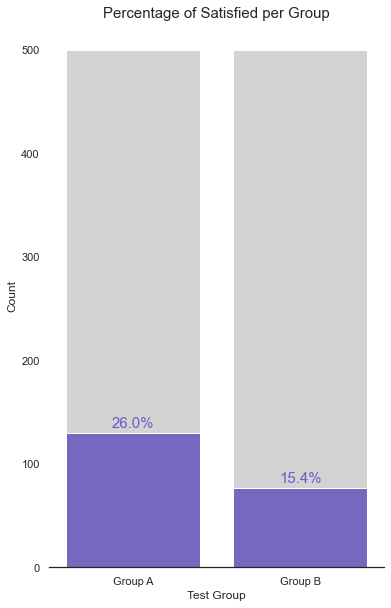

In [531]:
# Plot stacked bars
plt.figure(figsize=(6, 10))

plot_total = sns.barplot(x=plot_data['Test Group'], 
                        y=plot_data['Total'], color='lightgrey')

plot_satisfied = sns.barplot(x=plot_data['Test Group'], 
                            y=plot_data['Satisfied'], color='slateblue')

# Set labels and title
plt.title('Percentage of Satisfied per Group', fontsize=15)
plt.ylabel('Count')
plt.tick_params(left=False,bottom=False,labelleft=True,labelbottom=True)

# Put values on top of bars
row_list = []
for index, row in plot_data[plot_data['Test Group'] == 'Group A'][['Satisfied', 'Satisfied Rate']].iterrows():
    plot_total.text(row.name, row['Satisfied']+5, str(round(100 * row['Satisfied Rate'], 2)) + '%', color='slateblue', ha="center", fontsize=15)
for index, row in plot_data[plot_data['Test Group'] == 'Group B'][['Satisfied', 'Satisfied Rate']].iterrows():
    plot_satisfied.text(row.name, row['Satisfied']+5, str(round(100 * row['Satisfied Rate'], 2)) + '%', color='slateblue', ha="center", fontsize=15)
# Show the plot
plt.show()